# 6章 物流の最適ルートをコンサルティングする１０本ノック

ここでは、「物流」の基礎となる「輸送最適化」を検討するにあたっての基礎的な技術を習得します。  
実際の物流データからネットワーク構造を可視化する方法について学び、最適な物流計画を立案する流れを学んでいきます。

### ノック５１：物流に関するデータを読み込んでみよう

In [1]:
import pandas as pd

factories = pd.read_csv("tbl_factory.csv", index_col=0)
factories

,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [2]:
warehouses = pd.read_csv("tbl_warehouse.csv", index_col=0)
warehouses

,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [3]:
cost = pd.read_csv("rel_cost.csv",index_col=0)
cost.head()

,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
trans = pd.read_csv("tbl_transaction.csv",index_col=0)
trans.head()

,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


In [5]:
join_data = pd.merge(trans,cost,left_on=["ToFC","FromWH"],right_on=["FCID","WHID"],how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [6]:
join_data = pd.merge(join_data, factories, left_on="ToFC",right_on="FCID",how="left")
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [7]:
join_data = pd.merge(join_data, warehouses, left_on="FromWH", right_on="WHID", how="left")
join_data = join_data[["TransactionDate","Quantity","Cost","ToFC","FCName","FCDemand","FromWH","WHName","WHSupply","WHRegion"]]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [8]:
kanto = join_data.loc[join_data["WHRegion"]=="関東"]
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [9]:
tohoku = join_data.loc[join_data["WHRegion"]=="東北"]
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


### ノック５２：現状の輸送量、コストを確認してみよう

In [10]:
print("関東支社の総コスト: " + str(kanto["Cost"].sum()) + "万円")
print("東北支社の総コスト: " + str(tohoku["Cost"].sum()) + "万円")

関東支社の総コスト: 2189.3万円
東北支社の総コスト: 2062.0万円


In [11]:
print("関東支社の総部品輸送個数: " + str(kanto["Quantity"].sum()) + "個")
print("東北支社の総部品輸送個数: " + str(tohoku["Quantity"].sum()) + "個")


関東支社の総部品輸送個数: 49146個
東北支社の総部品輸送個数: 50214個


In [12]:
tmp =(kanto["Cost"].sum() / kanto["Quantity"].sum()) * 10000
print("関東支社の部品1つ当たりの輸送コスト:" + str(int(tmp)) + "円")
tmp =(tohoku["Cost"].sum() / tohoku["Quantity"].sum()) * 10000
print("東北支社の部品1つ当たりの輸送コスト:" + str(int(tmp)) + "円")

関東支社の部品1つ当たりの輸送コスト:445円
東北支社の部品1つ当たりの輸送コスト:410円


In [13]:
cost_chk =pd.merge(cost, factories, on="FCID",how="left")
print("東京支社の平均輸送コスト: " + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="関東"].mean()) + "万円")
print("東北支社の平均輸送コスト: " + str(cost_chk["Cost"].loc[cost_chk["FCRegion"]=="東北"].mean()) + "万円")

東京支社の平均輸送コスト: 1.075万円
東北支社の平均輸送コスト: 1.05万円


### ノック５３：ネットワークを可視化してみよう

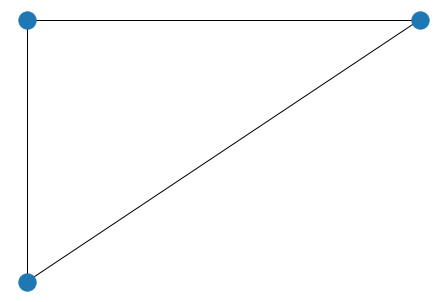

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

#グラフオブジェクトの作成
G=nx.Graph()

#頂点の設定
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")

#辺の設定
G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")

#座標の設定
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)

#描画
nx.draw(G,pos)

#表示
plt.show()

### ノック５４：ネットワークにノードを追加してみよう

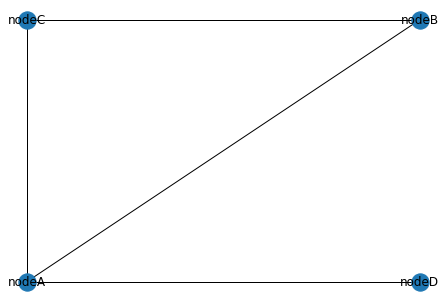

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

#グラフオブジェクトの作成
G=nx.Graph()

#頂点の設定
G.add_node("nodeA")
G.add_node("nodeB")
G.add_node("nodeC")
G.add_node("nodeD")


#辺の設定
G.add_edge("nodeA","nodeB")
G.add_edge("nodeA","nodeC")
G.add_edge("nodeB","nodeC")
G.add_edge("nodeA","nodeD")


#座標の設定
pos={}
pos["nodeA"]=(0,0)
pos["nodeB"]=(1,1)
pos["nodeC"]=(0,1)
pos["nodeD"]=(1,0)


#描画
nx.draw(G,pos, with_labels = True)

#表示
plt.show()

### ノック５５：ルートの重みづけを実施しよう

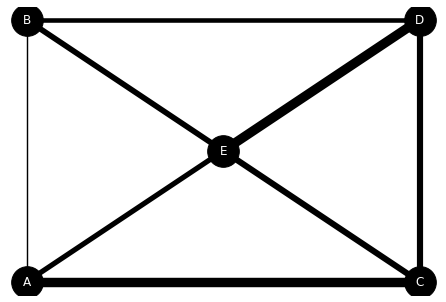

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#データ読み込み
df_w = pd.read_csv("network_weight.csv")
df_p = pd.read_csv("network_pos.csv")

#エッジの重みのリスト化
size = 10
edge_weights = []
for i in range(len(df_w)):
    for j in range(len(df_w.columns)):
        edge_weights.append(df_w.loc[i][j]*size)

#グラフオブジェクトの作成
G = nx.Graph()

#頂点の設定
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

#辺の設定
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        G.add_edge(df_w.columns[i],df_w.columns[j])

#座標の設定
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0],df_p[node][1])

#描画
nx.draw(G,pos,with_labels=True,font_sise=16,node_size=1000,node_color="k",font_color="w",width=edge_weights)

#表示
plt.show()

### ノック５６：輸送ルート情報を読み込んでみよう

In [17]:
import pandas as pd

df_tr = pd.read_csv("trans_route.csv",index_col="工場")
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


### ノック５７：輸送ルート情報からネットワークを可視化してみよう

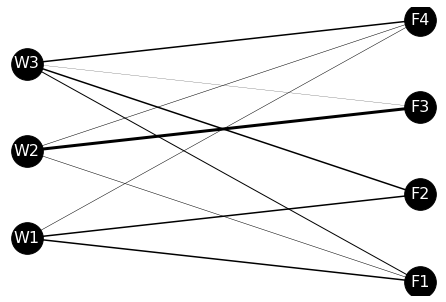

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

df_tr = pd.read_csv("trans_route.csv",index_col="工場")
df_pos = pd.read_csv("trans_route_pos.csv")

G = nx.Graph()

#頂点の設定
for i in range(len(df_pos.columns)):
        G.add_node(df_pos.columns[i])

#辺の設定＆エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            #辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            #エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                        
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size 
                edge_weights.append(weight)
#座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node]= (df_pos[node][0],df_pos[node][1])
    
#描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color="k", font_color="w", width=edge_weights)

#表示
plt.show()


### ノック５８：輸送コスト関数を作成しよう

In [50]:
import pandas as pd

#データ読み込み
df_tr = pd.read_csv("trans_route.csv", index_col="工場")
df_tc = pd.read_csv("trans_cost.csv", index_col="工場")

#輸送コスト関数
def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i][j]*df_tc.iloc[i][j]
    return cost

print("総輸送コスト:"+str(trans_cost(df_tr,df_tc)))

総輸送コスト:1493


### ノック５９：制約条件を作ってみよう

In [54]:
import pandas as pd

#データ読み込み
df_tr = pd.read_csv("trans_route.csv", index_col="工場")
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")

#需要側の制約条件
for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    print(str(df_demand.columns[i])+"への輸送量:"+str(temp_sum)+"(需要量:"+str(df_demand.iloc[0][i])+")")
    if temp_sum>=df_demand.iloc[0][i]:
        print("需要量を満たしています。")
    else:
        print("需要を満たしていません。輸送ルートを再計算してください。")
#供給側の制約条件
for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    print(str(df_supply.columns[i])+"からの輸送量:"+str(temp_sum)+"(供給限界:"+str(df_supply.iloc[0][i])+")")
    if temp_sum<=df_supply.iloc[0][i]:
        print("供給限界の範囲内です。")
    else:
        print("供給限界を超過しています。輸送ルートを再計算してください。")

F1への輸送量:30(需要量:28)
需要量を満たしています。
F2への輸送量:30(需要量:29)
需要量を満たしています。
F3への輸送量:32(需要量:31)
需要量を満たしています。
F4への輸送量:25(需要量:25)
需要量を満たしています。
W1からの輸送量:35(供給限界:35)
供給限界の範囲内です。
W2からの輸送量:40(供給限界:41)
供給限界の範囲内です。
W3からの輸送量:42(供給限界:42)
供給限界の範囲内です。


### ノック６０：輸送ルートを変更して、輸送コスト関数の変化を確認しよう

In [66]:
import pandas as pd
import numpy as np

#データ読み込み
df_tr_new = pd.read_csv("trans_route_new.csv", index_col="工場")
print(df_tr_new)

#総輸送コスト再計算
print("総輸送コスト（変更後）:"+str(trans_cost(df_tr_new,df_tc)))

#制約条件計算関数
#需要側
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
#供給側
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i]= 1
    return flag

print("需要条件計算結果:"+str(condition_demand(df_tr_new,df_demand)))
print("供給条件計算結果:"+str(condition_supply(df_tr_new,df_supply)))



    F1  F2  F3  F4
工場                
W1  15  15   0   0
W2   5   0  30  10
W3  10  15   2  15
総輸送コスト（変更後）:1428
需要条件計算結果:[1. 1. 1. 1.]
供給条件計算結果:[1. 0. 1.]


,F1,F2,F3,F4
0,28,29,31,25


In [64]:
df_tr

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15
